In [1]:
import torch, torchvision
import torch.nn as nn
from torchsummary import summary

import torch.nn.functional as F
import numpy as np
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataset_path, train=True):
        dataset_path = os.path.normpath(dataset_path)
        self.x = []
        n  = 0
        if train:
            n  = 0
            for category in os.listdir(dataset_path):
                for img in os.listdir(os.path.join(dataset_path, category)):
                    self.x.append(os.path.join(dataset_path, category, img))
                n += 1
                if n > 30:
                    break
        else:
            n  = 0
            for category in os.listdir(dataset_path):
                if n>30:
                    for img in os.listdir(os.path.join(dataset_path, category)):
                        self.x.append(os.path.join(dataset_path, category, img))
                n += 1
                if n> 40:
                    break
        self.x = np.array(self.x)
        
    def __len__(self):
        return len(self.x)   
    
    def __getitem__(self, ix):
        return (torchvision.io.read_image(self.x[ix])/255.).to(device)

In [4]:
ds_train = CustomDataset("D:/DATASETS/animals/images", True)
ds_val = CustomDataset("D:/DATASETS/animals/images", False)
dl_train = DataLoader(ds_train, batch_size=8, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=True)

In [5]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x)

        qkv = qkv.chunk(3, dim = -1)
        
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        
        attn = self.attend(dots)
        
        out = torch.matmul(attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        i = 0
        for attn, ff in self.layers:
            i+=1
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        
        x += self.pos_embedding[:, :(n + 1)]
        
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)
    
        return x
    

class ViTAutoencoder(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.decoder_pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width).to(device),
            nn.Linear(patch_dim, dim).to(device),
        )
        self.back_to_img = nn.Sequential(
            nn.Linear(dim, patch_dim).to(device),
            Rearrange('b (n1 n2) (p1 p2 c) -> b c (n1 p1) (n2 p2)', p1 = patch_height, p2 = patch_width, n1=(image_height // patch_height), n2=image_width // patch_width).to(device)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.encoder_transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        #For now we use the same transformer architecture for both the encoder and the decoder, but this could change.
        self.decoder_transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        
    def encoder(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        x += self.pos_embedding

        x = self.dropout(x)

        x = self.encoder_transformer(x)

        return x
    
    def decoder(self, x):
        
        x += self.decoder_pos_embedding

        x = self.decoder_transformer(x)
        
        x = self.dropout(x)
        
        imgs = self.back_to_img(x)
    
        return imgs

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [7]:
image_size = 224
patch_size = 16
num_classes = 20
dim = 16*16*3
depth = 6
heads = 6
mlp_dim = 256

model = ViTAutoencoder(image_size, patch_size, num_classes, dim, depth, heads, mlp_dim)

In [8]:
summary(model, torch.zeros(5, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 196, 768]            --
|    └─Rearrange: 2-1                    [-1, 196, 768]            --
|    └─Linear: 2-2                       [-1, 196, 768]            590,592
├─Dropout: 1-2                           [-1, 196, 768]            --
├─Transformer: 1-3                       [-1, 196, 768]            --
├─Transformer: 1-4                       [-1, 196, 768]            --
├─Dropout: 1-5                           [-1, 196, 768]            --
├─Sequential: 1-6                        [-1, 3, 224, 224]         --
|    └─Linear: 2-3                       [-1, 196, 768]            590,592
|    └─Rearrange: 2-4                    [-1, 3, 224, 224]         --
Total params: 1,181,184
Trainable params: 1,181,184
Non-trainable params: 0
Total mult-adds (M): 40.14
Input size (MB): 2.87
Forward/backward pass size (MB): 2.30
Params size (MB): 4.51
Estimated Total Size (MB): 9.

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 196, 768]            --
|    └─Rearrange: 2-1                    [-1, 196, 768]            --
|    └─Linear: 2-2                       [-1, 196, 768]            590,592
├─Dropout: 1-2                           [-1, 196, 768]            --
├─Transformer: 1-3                       [-1, 196, 768]            --
├─Transformer: 1-4                       [-1, 196, 768]            --
├─Dropout: 1-5                           [-1, 196, 768]            --
├─Sequential: 1-6                        [-1, 3, 224, 224]         --
|    └─Linear: 2-3                       [-1, 196, 768]            590,592
|    └─Rearrange: 2-4                    [-1, 3, 224, 224]         --
Total params: 1,181,184
Trainable params: 1,181,184
Non-trainable params: 0
Total mult-adds (M): 40.14
Input size (MB): 2.87
Forward/backward pass size (MB): 2.30
Params size (MB): 4.51
Estimated Total Size (MB): 9.

In [9]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

In [10]:
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [11]:
criterion = nn.MSELoss()
#It is very sensible to the learning rate, a higher learning rate is unstable
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5)

In [12]:
num_epochs = 200
lowest_loss = 100000000
for epoch in range(num_epochs):
    print("Epoch ", epoch+1)
    total_loss = 0
    for ix, data in enumerate(dl_train):
        loss = train_batch(data, model, criterion, optimizer)
        total_loss += loss
    print(total_loss)
    if total_loss < lowest_loss:
        best_model = model
    

Epoch  1
tensor(51.7777, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  2
tensor(5.8019, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  3
tensor(2.6354, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  4
tensor(1.8555, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  5
tensor(1.5205, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  6
tensor(1.3214, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  7
tensor(1.1631, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  8
tensor(1.0641, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  9
tensor(0.9803, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  10
tensor(0.9055, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  11
tensor(0.8512, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  12
tensor(0.8063, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  13
tensor(0.7610, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  14
tensor(0.7334, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  15
tensor(0.6849, device='cuda:0', grad_fn=<AddBackward0>)
Epoch  16
tensor(0

KeyboardInterrupt: 

In [15]:
torch.save(best_model, "vit_autoencoder_v1.pt")

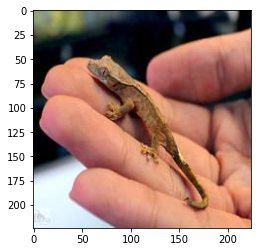

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


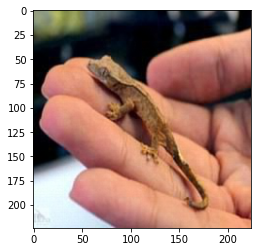

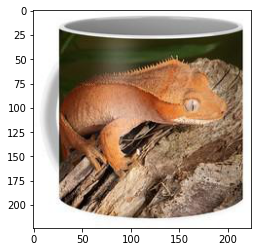

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


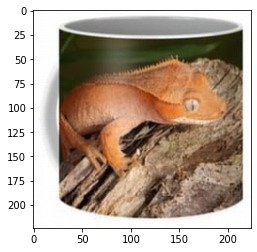

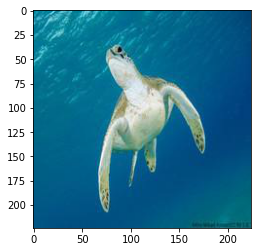

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


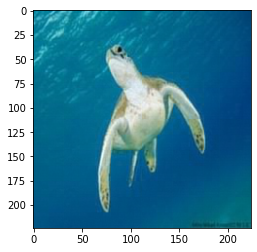

In [14]:
for _ in range(3):
    ix = np.random.randint(len(ds_val))
    im = ds_val[ix]
    best_model.eval()
    _im = best_model(im[None])[0]
    _im = _im.cpu().detach().numpy()
    #fig, ax = plt.subplots(1, 2, figsize=(3,3))
    plt.imshow(im.cpu().permute(1,2,0))
    plt.show()
    plt.imshow(_im.transpose(1,2,0))
    plt.show()